# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models, utils

import matplotlib.pyplot as plt

import os
from collections import OrderedDict

In [2]:
# DEFINING CONSTANTS TO BE USED

# IMAGE AND BATCHES
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
IMG_RESIZE = (255, 255)
BATCH_SIZE = 64
ROTATION = 30

# FOR DATASETS
DATASETS = ['train', 'valid', 'test']
NUM_CLASSES = 102 # Total number of categories in dataset

# FOR PICKING A MODEL ARCHITECTURE TO USE
ARCHITECTURES = ['vgg', 'alexnet', 'densenet']

# FOR NORMALIZING IMAGES
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# FOR MODEL DEFINITION AND TRAINING
CHOICE_ARCH = 'alexnet' # This would be set by command-line arguments
NUM_EPOCHS = 25
LEARNING_RATE = 0.003
HIDDEN_UNITS = 1024
USE_CUDA = True
DROPOUT_RATE = 0.5
DEVICE = "cuda" if USE_CUDA and torch.cuda.is_available() else "cpu"

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [3]:
data_dir = 'flowers'

data_dirs = {
    DATASETS[i]: os.path.join(data_dir, DATASETS[i])
    for i in range(len(DATASETS))
}

data_dirs

{'train': 'flowers\\train', 'valid': 'flowers\\valid', 'test': 'flowers\\test'}

In [4]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(data_dir)

There are 3 directories and 0 images in 'flowers'.
There are 102 directories and 0 images in 'flowers\test'.
There are 0 directories and 5 images in 'flowers\test\1'.
There are 0 directories and 3 images in 'flowers\test\10'.
There are 0 directories and 8 images in 'flowers\test\100'.
There are 0 directories and 4 images in 'flowers\test\101'.
There are 0 directories and 6 images in 'flowers\test\102'.
There are 0 directories and 9 images in 'flowers\test\11'.
There are 0 directories and 9 images in 'flowers\test\12'.
There are 0 directories and 6 images in 'flowers\test\13'.
There are 0 directories and 3 images in 'flowers\test\14'.
There are 0 directories and 4 images in 'flowers\test\15'.
There are 0 directories and 3 images in 'flowers\test\16'.
There are 0 directories and 9 images in 'flowers\test\17'.
There are 0 directories and 6 images in 'flowers\test\18'.
There are 0 directories and 7 images in 'flowers\test\19'.
There are 0 directories and 5 images in 'flowers\test\2'.
There

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [6]:
import numpy as np

# Helper Function 1
def plot_image(image):
    # Turn the image into an array
    img_as_array = np.asarray(image)

    # Plot the image with matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(img_as_array)
    plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
    plt.axis(False)
    plt.tight_layout()

Random image path: flowers\train\65\image_03187.jpg
Image class: californian poppy
Image height: 500
Image width: 752


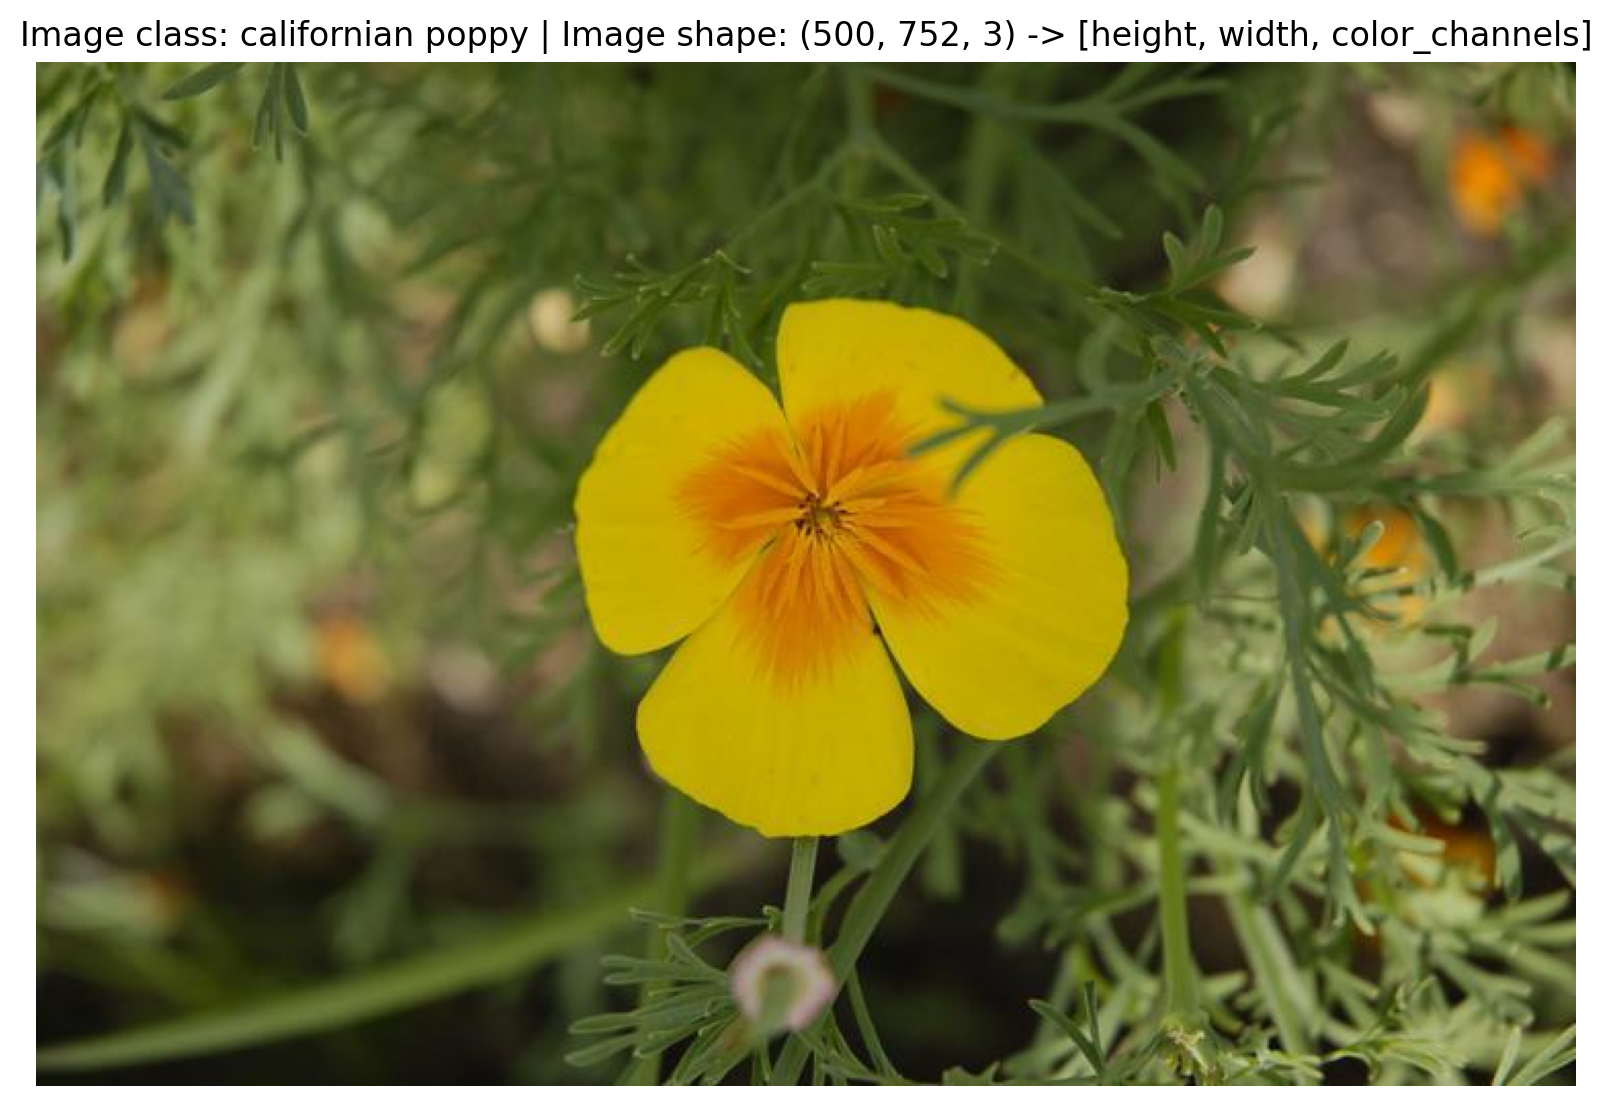

In [7]:
import random
import glob
from pathlib import Path
from PIL import Image

# 1. Get all image paths
image_path_list = glob.glob(f"{data_dir}/*/*/*.jpg")
# print(f"Image Path List: {image_path_list}")

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
def get_class(image_path):
    return cat_to_name[Path(image_path).parent.stem]

image_class = get_class(random_image_path)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

plot_image(img)


In [8]:
# TODO: Define your transforms for the training, validation, and testing sets
# https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model
data_transforms = {
    DATASETS[0]: transforms.Compose([transforms.RandomRotation(ROTATION),
                                 transforms.RandomResizedCrop(IMG_SIZE),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(MEAN, STD)]),

    DATASETS[1]: transforms.Compose([transforms.Resize(IMG_RESIZE),
                                transforms.CenterCrop(IMG_SIZE),
                                transforms.ToTensor(),
                                transforms.Normalize(MEAN, STD)]),

    DATASETS[2]: transforms.Compose([transforms.Resize(IMG_RESIZE),
                                transforms.CenterCrop(IMG_SIZE),
                                transforms.ToTensor(),
                                transforms.Normalize(MEAN, STD)])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    key: datasets.ImageFolder(data_dirs[key], transform=data_transforms[key])

    for key in DATASETS
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    key: torch.utils.data.DataLoader(image_datasets[key], batch_size=BATCH_SIZE, shuffle=True)

    for key in DATASETS
}

dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1e97ee1b380>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x1e97cca7260>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1e97ee1ac90>}

In [9]:
# Get the data set sizes:
dataset_sizes = {key: len(image_datasets[key]) for key in DATASETS}
print("Dataset Sizes: ", dataset_sizes)
print()

# Get the class names from the training dataset:
class_names = image_datasets['train'].classes
print("Class Names", class_names);
print()

# Get the # of classes (Useful to figure out what the output size for our last layer in the network should be)
# By inspecting the folder, we can see that it should be 102, but I do not want to hard code this
num_classes = len(class_names)
print("Number of classes: ", num_classes);

assert NUM_CLASSES == num_classes

Dataset Sizes:  {'train': 6552, 'valid': 818, 'test': 819}

Class Names ['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']

Number of classes:  102


In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(img)
            ax[0].set_title(f"Original \nSize: {img.size}")
            ax[0].axis("off")

            # Transform and plot image
            transformed_image = transform(img).numpy().transpose((1, 2, 0))

            # Normalize
            transformed_image = STD * transformed_image + MEAN
            transformed_image = np.clip(transformed_image, 0, 1)

            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {get_class(image_path)}", fontsize=16)

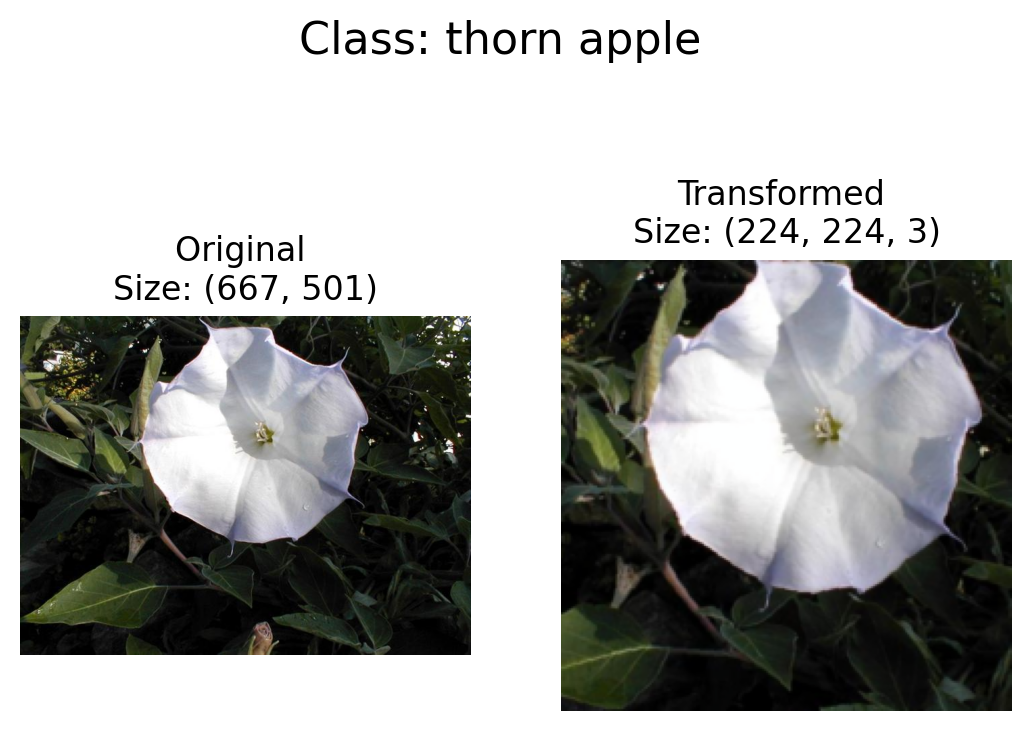

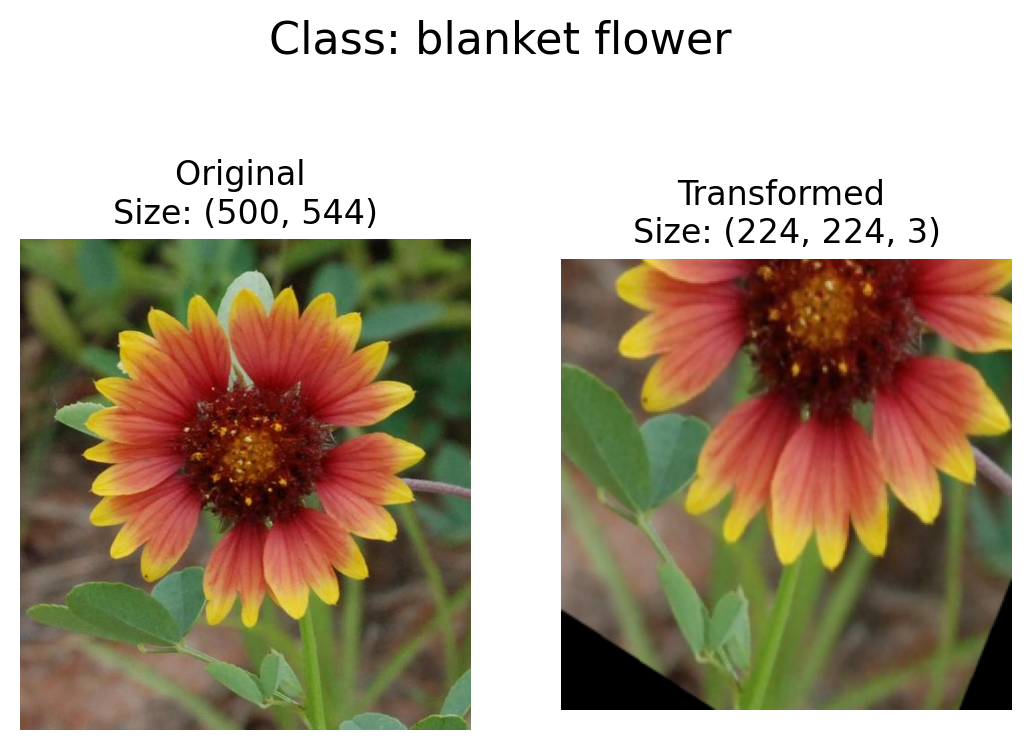

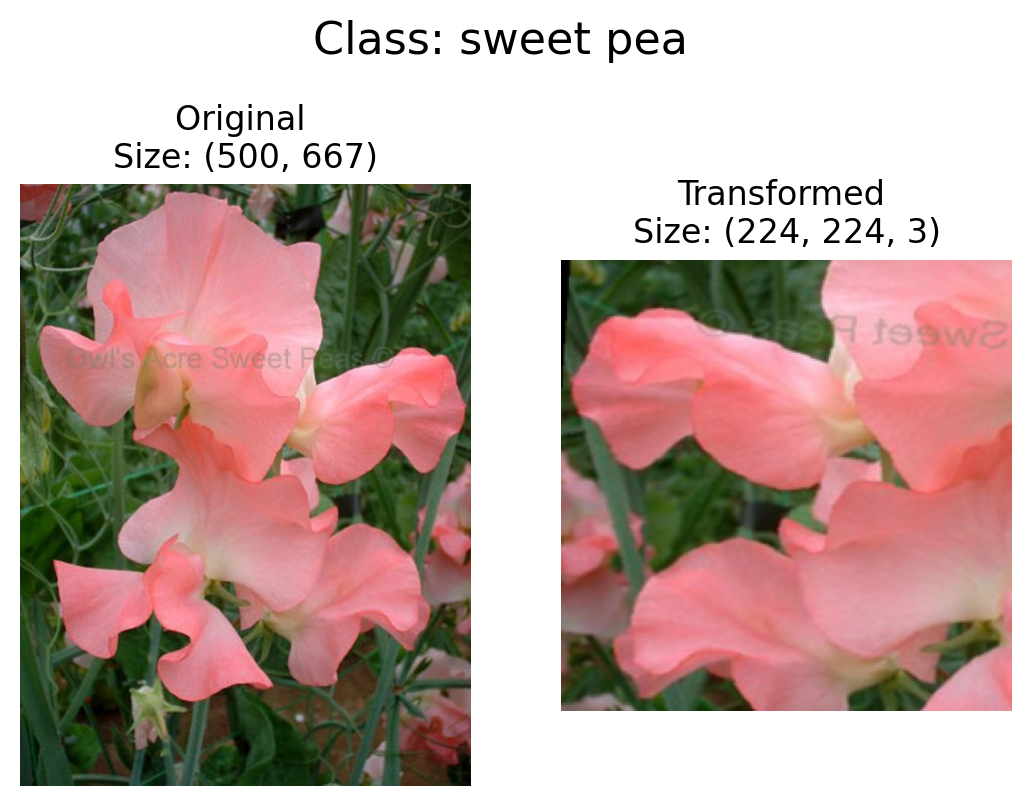

In [11]:
plot_transformed_images(image_path_list, transform=data_transforms[DATASETS[0]], n=3)

Inputs Shape: torch.Size([64, 3, 224, 224])
Classes Shape: torch.Size([64])


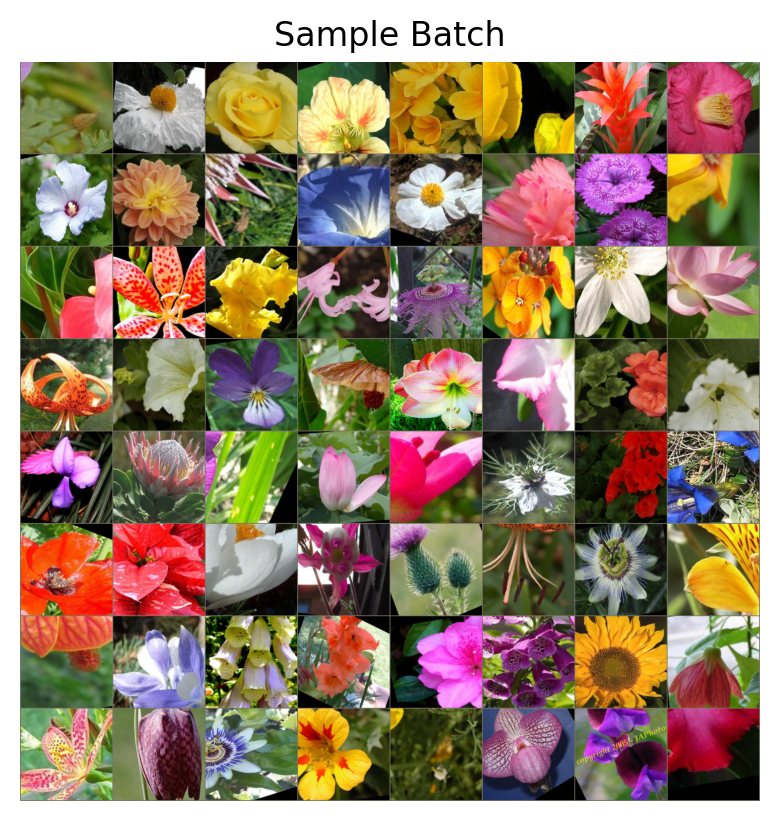

In [12]:
# Again, I used code from the PyTorch.org tutorial on transfer learning
# Link: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

print(f"Inputs Shape: {inputs.shape}")
print(f"Classes Shape: {classes.shape}")

# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title='Sample Batch')

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [13]:
# THIS WAS ALREADY DONE BEFORE
# import json
#
# with open('cat_to_name.json', 'r') as f:
#     cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [14]:
def set_parameter_requires_grad(model):
    """
    This simple function just sets the .requires_grad
    attribute for each model parameter to false.
    We do this since we are feature extracting.
    """
    for param in model.parameters():
        param.requires_grad = False

In [15]:
def get_classifier(model, num_features):

    return nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(num_features, HIDDEN_UNITS)),
        ('drop', nn.Dropout(DROPOUT_RATE)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(HIDDEN_UNITS, NUM_CLASSES)),
        ('output', nn.LogSoftmax(dim=1))
    ]))

In [16]:
def initialize_model(model_name='vgg'):
    """Initialize our model."""

    model_ft = None

    # use if and elif statements to check which one of the pre-trained
    # models we want to use
    if model_name == ARCHITECTURES[0]:

        model_ft = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
        set_parameter_requires_grad(model_ft)

        # get the number of input features from the 1st layer
        # of the 'original' classifier
        num_features = model_ft.classifier[1].in_features

        # replace the entire classifier
        model_ft.classifier = get_classifier(model_ft, num_features)

    elif model_name == ARCHITECTURES[1]:

        model_ft = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        set_parameter_requires_grad(model_ft)

        # get the number of input features from the 0th layer
        # of the 'original' classifier
        num_features = model_ft.classifier[0].in_features

        # replace the entire classifier
        model_ft.classifier = get_classifier(model_ft, num_features)

    elif model_name == ARCHITECTURES[2]:

        model_ft = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        set_parameter_requires_grad(model_ft)

        # get the number of input features from
        # of the 'original' classifier
        num_features = model_ft.classifier.in_features

        # replace the entire classifier
        model_ft.classifier = get_classifier(model_ft, num_features)

    model_ft.to(DEVICE)
    return model_ft

In [17]:
# Initialize the model
model_ft = initialize_model(CHOICE_ARCH)

In [18]:
try:
    from torchinfo import summary
except ImportError:
    print(f"torch info not installed, printing model: ")
    print(model_ft)
else:
    print(summary(model_ft, [1, 3, *IMG_SIZE]))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 102]                  --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]    

In [19]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(dataloaders['train']))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
one_image, one_label = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {one_image.shape}\n")
img

# 3. Perform a forward pass on a single image
one_image, one_label = one_image.to(DEVICE), one_label.to(DEVICE)

with torch.no_grad():
    pred = model_ft(one_image)

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output logits length:\n{len(pred)}\n")
print(f"Output logits shape:\n{pred.shape}\n")
print(f"Output prediction probabilities:\n{torch.exp(pred)}\n")
print(f"Output prediction probabilities sum:\n{torch.sum(torch.exp(pred))}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{one_label}\n")

ps = torch.exp(pred)
top_p, top_class = ps.topk(1, dim=1)
equals = top_class == one_label.view(*top_class.shape)
test_correct = equals.sum().item()

print(f"Top P: {top_p}, Top class: {top_class}")
print(f"Equals: {equals}\n")
print(f"Test correct: {test_correct}")
print(f"Test Accuracy: {test_correct*100:.2f}%")


Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[-5.1008, -5.1276, -4.4774, -4.8895, -4.6599, -4.6219, -4.6403, -4.1624,
         -4.8528, -4.4442, -4.5742, -5.2461, -4.4036, -4.3857, -5.2396, -4.2198,
         -5.1282, -4.9703, -5.3984, -4.4678, -4.4057, -5.1977, -4.8121, -4.0876,
         -5.0120, -3.8571, -4.6132, -5.4953, -4.5224, -5.1029, -4.4698, -5.0137,
         -4.4649, -4.5643, -3.7113, -4.6453, -5.1603, -4.9766, -4.9443, -4.5327,
         -4.6133, -5.4533, -4.9768, -4.1953, -4.8844, -5.3127, -5.2715, -4.0530,
         -4.6640, -4.6900, -4.6932, -4.4366, -4.5820, -4.5708, -4.4776, -4.2843,
         -4.4221, -4.8760, -4.9363, -4.4436, -4.7027, -5.0826, -4.5023, -4.6625,
         -4.7813, -4.7190, -4.7165, -4.5900, -4.0837, -4.5494, -4.8206, -4.6791,
         -5.2930, -4.5919, -5.2925, -4.9790, -4.1776, -5.5236, -4.8892, -4.4313,
         -4.4570, -4.2962, -4.0796, -3.8801, -5.0771, -4.3599, -4.1715, -5.3346,
         -4.9732, -4.7099, -4.4927, -5.0881,

In [20]:
def train_step(model, dataloader, criterion, optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_correct = 0, 0

    # Iterate over train or valid data (depends on
    # the phase that we are in)
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        # Forward Pass

        logps = model(inputs)
        loss = criterion(logps, labels)
        train_loss += loss.item() * inputs.size(0)

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()

        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_correct += equals.sum().item()

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader.dataset)
    train_acc = train_correct / len(dataloader.dataset)

    return train_loss, train_acc

In [21]:
def valid_step(model, dataloader, criterion):
   # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    valid_loss, valid_correct = 0, 0

    # Turn on inference context manager
    with torch.no_grad():
        # Loop through DataLoader batches
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # 1. Forward pass
            logps = model.forward(inputs)

            # 2. Calculate and accumulate loss
            loss = criterion(logps, labels)
            valid_loss += loss.item()

            # Calculate and accumulate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            valid_correct += equals.sum().item()

    # Adjust metrics to get average loss and accuracy per batch
    valid_loss = valid_loss / len(dataloader.dataset)
    valid_acc = valid_correct / len(dataloader.dataset)
    return valid_loss, valid_acc

In [22]:
use_tqdm = False

try:
    from tqdm.auto import tqdm
except ImportError:
    print(f"tqdm not installed")
else:
    use_tqdm = True

In [23]:
def train(model, dataloaders, optimizer, criterion, num_epochs=NUM_EPOCHS):

    model.to(DEVICE)
   # 2. Create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "valid_loss": [],
        "valid_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(num_epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=dataloaders['train'],
                                           criterion=criterion,
                                           optimizer=optimizer)

        valid_loss, valid_acc = valid_step(model=model,
                                           dataloader=dataloaders['valid'],
                                           criterion=criterion)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"valid_loss: {valid_loss:.4f} | "
            f"valid_acc: {valid_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [24]:
# Train the model
from timeit import default_timer as timer
start_time = timer()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.classifier.parameters(), lr=LEARNING_RATE)

model_results = train(model_ft, dataloaders, optimizer, criterion, num_epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.3696 | train_acc: 0.0748 | valid_loss: 0.0621 | valid_acc: 0.1724
Epoch: 2 | train_loss: 3.8377 | train_acc: 0.1870 | valid_loss: 0.0517 | valid_acc: 0.3154
Epoch: 3 | train_loss: 3.3626 | train_acc: 0.2891 | valid_loss: 0.0428 | valid_acc: 0.4866
Epoch: 4 | train_loss: 2.9486 | train_acc: 0.3758 | valid_loss: 0.0363 | valid_acc: 0.5501
Epoch: 5 | train_loss: 2.6162 | train_acc: 0.4357 | valid_loss: 0.0312 | valid_acc: 0.6235
Epoch: 6 | train_loss: 2.3727 | train_acc: 0.4821 | valid_loss: 0.0271 | valid_acc: 0.6687
Epoch: 7 | train_loss: 2.1520 | train_acc: 0.5319 | valid_loss: 0.0240 | valid_acc: 0.6883
Epoch: 8 | train_loss: 1.9952 | train_acc: 0.5554 | valid_loss: 0.0217 | valid_acc: 0.7335
Epoch: 9 | train_loss: 1.8621 | train_acc: 0.5803 | valid_loss: 0.0197 | valid_acc: 0.7555
Epoch: 10 | train_loss: 1.7400 | train_acc: 0.6039 | valid_loss: 0.0180 | valid_acc: 0.7677
Epoch: 11 | train_loss: 1.6526 | train_acc: 0.6250 | valid_loss: 0.0168 | valid_acc: 0.78

In [25]:
def plot_loss_curves(results):

    results = dict(list(model_results.items()))

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['valid_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['valid_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='valid_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='valid_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

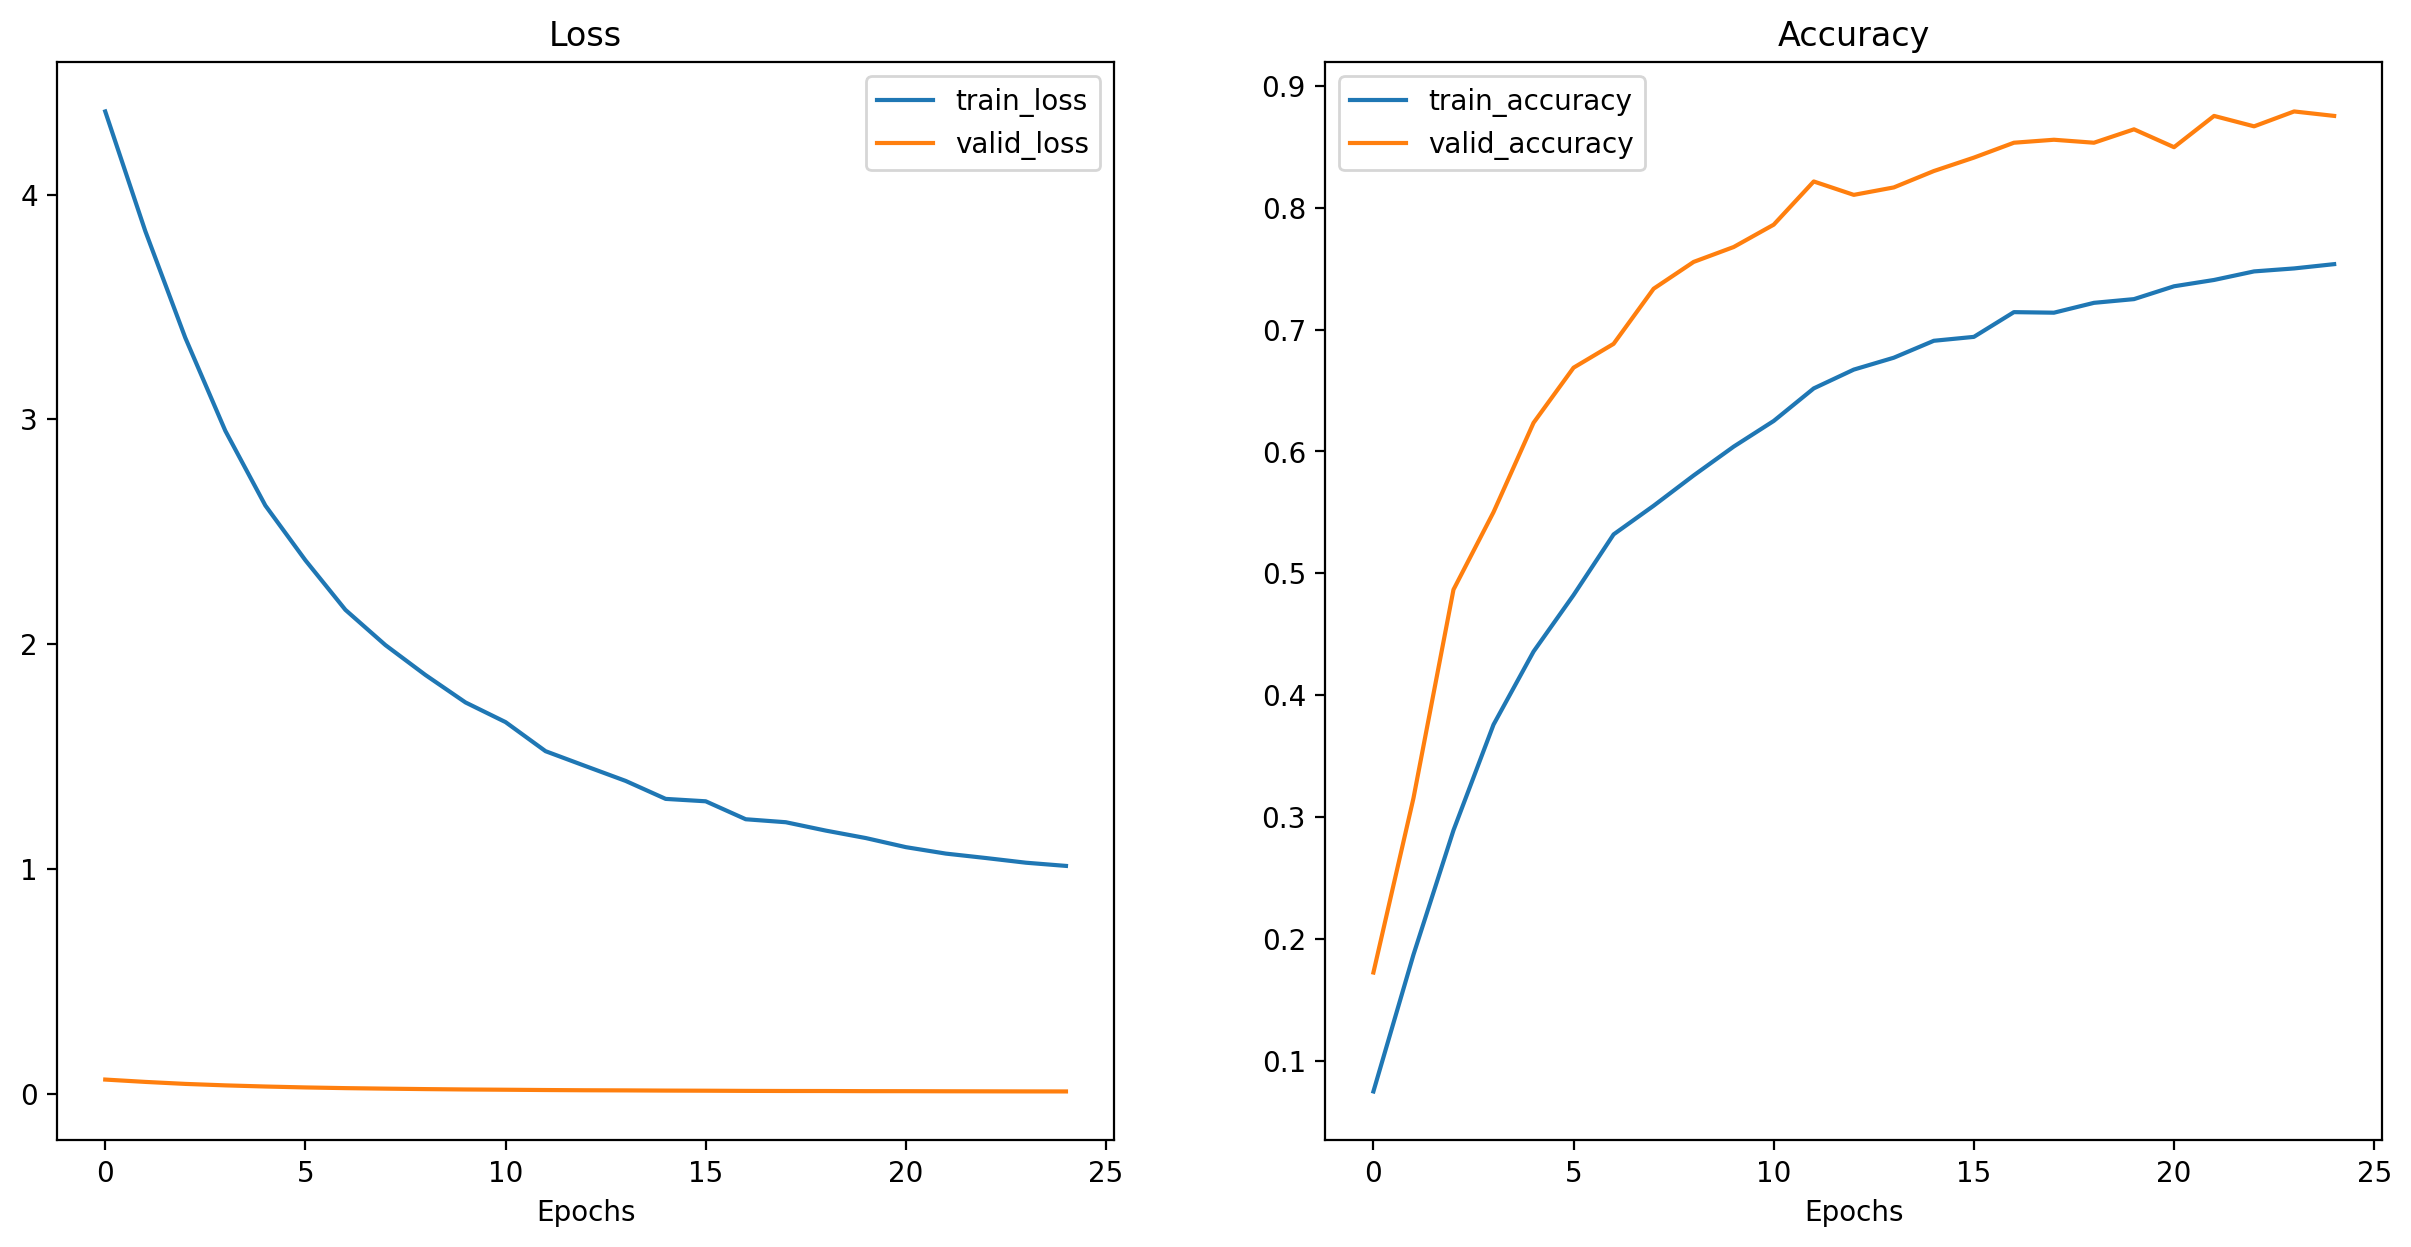

In [26]:
plot_loss_curves(model_results)

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [32]:
def check_accuracy_on_test_data(model, dataloader, device):
    correct, total = 0, 0

    model.to(device)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            logps = model(inputs)
            top_p, top_class = logps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            correct += equals.sum().item()
            total += labels.size(0)

    print(f"Accuracy of the network on the {dataset_sizes[DATASETS[2]]} test images:{(correct/total)*100:.2f}%")



In [33]:
check_accuracy_on_test_data(model_ft, dataloaders[DATASETS[2]], DEVICE)

Accuracy of the network on the 819 test images:84.25%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [ ]:
# TODO: Save the checkpoint 

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [ ]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [ ]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
# TODO: Display an image along with the top 5 classes